<a href="https://colab.research.google.com/github/albercej/zrh/blob/main/Precidcting_BTC_PytorchLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Predicting the price of Bitcoin with multivariate Pytorch LSTMs
Using multivariate, multi-output forecasting models for financial data

### Introduction: predicting the price of Bitcoin
For this problem, we’re going to focus on financial data. Before we begin, I would like to point out that LSTMs will not make you rich, even if they are excellent forecasters for time-series data. No model will make you rich; there’s a whole field of thinking on epistemic humility and how impossible it is for anything you do to detect any edge in the market; I won’t go into it here. But know this: if you’ve found an inconsistency in the price of a stock (it’s too low, or too high and you want to capitalise on that), and you believe that no-one else has spotted this inconsistency, then you might want to rethink your surety. Recall that “no-one else” in this scenario includes the team of PhDs sitting in Goldman Sachs with a supercomputing cluster, the lowest latency in information and order processing in the market, and multi-billion dollar financial incentives to find exactly the same inconsistencies as you. If you really believe you’ve beaten them, you haven’t. For more detail on this line of thinking, see Eliezer Yudkowsky’s Inadequate Equilibria.

We’ll frame our problem as follows. We have historical price data for Bitcoin, which includes the following predictors for each day (where we have daily time steps):

Opening price
High price
Low price
Volume traded
Our goal is to take some sequence of the above four values (say, for 100 previous days), and predict the target variable (Bitcoin’s price) for the next 50 days into the future.

In [2]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.4 MB 35.3 MB/s 
     |████████████████████████████████| 62 kB 1.7 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.28.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [38]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore")

from lightgbm import LGBMRegressor
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [39]:
df = yf.download("BTC-USD", start="2020-01-01", end=None)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-01,7194.892090,7254.330566,7174.944336,7200.174316,7200.174316,18565664997
2020-01-02,7202.551270,7212.155273,6935.270020,6985.470215,6985.470215,20802083465
2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277,7344.884277,28111481032
2020-01-04,7345.375488,7427.385742,7309.514160,7410.656738,7410.656738,18444271275
2020-01-05,7410.451660,7544.497070,7400.535645,7411.317383,7411.317383,19725074095
...,...,...,...,...,...,...
2022-06-25,21233.609375,21520.914062,20964.585938,21502.337891,21502.337891,18372538715
2022-06-26,21496.494141,21783.724609,21016.269531,21027.294922,21027.294922,18027170497
2022-06-27,21028.238281,21478.089844,20620.199219,20735.478516,20735.478516,20965695707


In [40]:
# Preprocessing the data
#df = pd.read_csv('BTC-USD.csv', index_col = 'Date', parse_dates=True)
df.drop(columns=['Adj Close'], inplace=True)
df.head(5)

,Open,High,Low,Close,Volume
Date,,,,,
2020-01-01,7194.892090,7254.330566,7174.944336,7200.174316,18565664997
2020-01-02,7202.551270,7212.155273,6935.270020,6985.470215,20802083465
2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277,28111481032
2020-01-04,7345.375488,7427.385742,7309.514160,7410.656738,18444271275
2020-01-05,7410.451660,7544.497070,7400.535645,7411.317383,19725074095


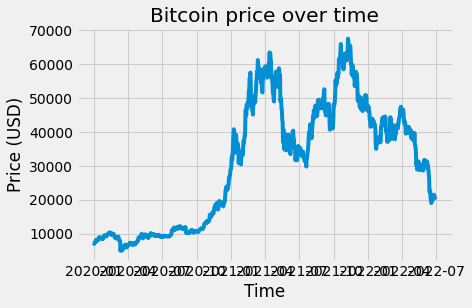

In [41]:
plt.plot(df.Close)
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.title("Bitcoin price over time")
plt.savefig("initial_plot.png", dpi=250)
plt.show();

In [42]:
# Setting inputs and outputs
X, y = df.drop(columns=['Close']), df.Close.values
X.shape, y.shape


((911, 4), (911,))

In [43]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()

X_trans = ss.fit_transform(X)
y_trans = mm.fit_transform(y.reshape(-1, 1))

Now comes the slightly fiddly part. We want to feed in 100 samples, up to the current day, and predict the next 50 time step values. To do this, we need a special function to ensure that the corresponding indices of X and y represent this structure. Examine this function carefully, but essentially it just boils down to getting 100 samples from X, then looking at the 50 next indices in y, and patching these together. Note that because of this we'll throw out the first 50 values of y.

In [44]:
# split a multivariate sequence past, future samples (X and y)
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X, y = list(), list() # instantiate X and y
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences): break
        # gather input and output of the pattern
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)

X_ss, y_mm = split_sequences(X_trans, y_trans, 100, 50)
print(X_ss.shape, y_mm.shape)

(763, 100, 4) (763, 50)


Let’s check that the first sample in y_mm indeed starts at the 100th sample in the original target y vector.

In [45]:

assert y_mm[0].all() == y_trans[99:149].squeeze(1).all()

y_mm[0]

array([0.03724359, 0.03026877, 0.03016636, 0.03195575, 0.02994198,
       0.02990029, 0.02670012, 0.03428358, 0.03395417, 0.03653389,
       0.03544372, 0.03053181, 0.03050569, 0.03429002, 0.03928262,
       0.04121847, 0.04152256, 0.04327876, 0.04512766, 0.0453107 ,
       0.06118997, 0.05891372, 0.06220806, 0.06418631, 0.0627305 ,
       0.06297309, 0.06441753, 0.06866207, 0.07956942, 0.07783045,
       0.07385624, 0.06047735, 0.05800699, 0.06124492, 0.06868165,
       0.07609001, 0.06961158, 0.07039144, 0.07508384, 0.07597585,
       0.07601519, 0.07272334, 0.06567466, 0.06728523, 0.06771194,
       0.06101952, 0.06288172, 0.06173337, 0.06726032, 0.07276759])

In [46]:
y_trans[99:149].squeeze(1)

array([0.03724359, 0.03026877, 0.03016636, 0.03195575, 0.02994198,
       0.02990029, 0.02670012, 0.03428358, 0.03395417, 0.03653389,
       0.03544372, 0.03053181, 0.03050569, 0.03429002, 0.03928262,
       0.04121847, 0.04152256, 0.04327876, 0.04512766, 0.0453107 ,
       0.06118997, 0.05891372, 0.06220806, 0.06418631, 0.0627305 ,
       0.06297309, 0.06441753, 0.06866207, 0.07956942, 0.07783045,
       0.07385624, 0.06047735, 0.05800699, 0.06124492, 0.06868165,
       0.07609001, 0.06961158, 0.07039144, 0.07508384, 0.07597585,
       0.07601519, 0.07272334, 0.06567466, 0.06728523, 0.06771194,
       0.06101952, 0.06288172, 0.06173337, 0.06726032, 0.07276759])

Above, we mentioned that we wanted to predict the data a several months into the future. Thus, we’ll use a training data size of 95%, with 5% left for the remaining data that we’re going to predict. This gives us a training set size of 2763 days, or about seven and a half years. We will predict 145 days into the future, which is almost 5 months.



In [47]:
total_samples = len(X)
train_test_cutoff = round(0.90 * total_samples)

X_train = X_ss[:-150]
X_test = X_ss[-150:]

y_train = y_mm[:-150]
y_test = y_mm[-150:] 

print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape)

Training Shape: (613, 100, 4) (613, 50)
Testing Shape: (150, 100, 4) (150, 50)


We need to now, as usual, convert our data into tensors. This is fairly easy — we do so by calling torch.tensor() on our object, and setting the property requires_grad=True. Some old Pytorch tutorials might have you believe that we need to apply the wrapper Variable here. However, this is deprecated, and now the input tensor to be forward propagated has to be can facilitate automatic back propagation (through backward()) without being wrapped in a variable.

In [59]:
# hide
import torch
import torch.nn as nn
from torch.autograd import Variable 

We need to now, as usual, convert our data into tensors. This is fairly easy - we do so by calling torch.tensor() on our object, and setting the property requires_grad=True. Some old Pytorch tutorials might have you believe that we need to apply the wrapper Variable here. However, this is deprecated, and now the input tensor to be forward propagated has to be can facilitate automatic back propagation (through backward()) without being wrapped in a variable.

In [60]:
# convert to pytorch tensors
X_train_tensors = Variable(torch.Tensor(X_train), requires_grad=True)
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

If we look at the documentation for the multi-layer torch.nn.LSTM, we see that the input shape depends on whether the parameter batch_first is true. Since we are accustomed to having the first dimension of our data be the batch, we will set batch_first to true. The size of the input is then (𝑁,𝐿,𝐻_𝑖𝑛), where 𝑁 is the batch size, 𝐿 is the sequence length, and 𝐻_𝑖𝑛 is the input size (i.e. the number of features). In other words, we want the dimensions to be the rows of the dataframe in the first dimension, followed by the length of the dataframe in the next dimension (representing the length of the input sequence), and finally the features (of which we have four) in the final dimension.

To reshape the tensors into our required shape, we use torch.reshape. This takes as arguments the tensors we are reshaping, and then a tuple of the shape we need to reshape to. For the rows of the dataframe, we can simply look at the shape of the first dimension of X_train_tensors.shape[0]. Since we are applying an LSTM, we recall that the sequence length we feed in is simply 1. (Remember that the whole point of the LSTM is not feeding in tonnes of data at each point, because the memory is handled by the inner workings of the LSTM cell. For more on this, see my previous article.) Finally, we want the last dimension to be the number of features, which is stored in X_train_tensors.shape[1].






In [61]:
# reshaping to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors,   
                                      (X_train_tensors.shape[0], 100, 
                                       X_train_tensors.shape[2]))
X_test_tensors_final = torch.reshape(X_test_tensors,  
                                     (X_test_tensors.shape[0], 100, 
                                      X_test_tensors.shape[2])) 

print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape: torch.Size([613, 100, 4]) torch.Size([613, 50])
Testing Shape: torch.Size([150, 100, 4]) torch.Size([150, 50])


One more thing we want to check: the data logic of the test set. Sequential data is hard to get your head around, especially when it comes to generating a test-set for multi-step output models. Here, we want to take the 100 previous predictors up to the current time-step, and predict 50 time-steps into the future. In the test set, we have 150 batch feature samples, each consisting of 100 time-steps and four feature predictors. In the targets for the test set, we again have 150 batch samples, each consisting of an array of length 50 of scalar outputs.

Since we want a way to validate our results, we need to predict the Bitcoin price for 50 time steps in the test set for which we have the data (i.e. the test targets). Because of the way we wrote split_sequence() above, we simply need the last sample of 100 days in X_test, run the model on it, and compare these predictions with the last sample of 50 days of y_test. These correspond to a period of 100 days in X_test's last sample, proceeded immediately by the next 50 days in the last sample of y_test.

We want to check that the 50 values we will be predicting match the last 50 values of y in the test set.

In [62]:
X_check, y_check = split_sequences(X, y.reshape(-1, 1), 100, 50)
X_check[-1][0:4]

array([[3.84817656e+04, 3.91151328e+04, 3.81136641e+04, 2.02885003e+10],
       [3.87437148e+04, 3.88346172e+04, 3.68327305e+04, 1.91551894e+10],
       [3.69448047e+04, 3.71546016e+04, 3.63755391e+04, 1.85915348e+10],
       [3.71492656e+04, 4.15277852e+04, 3.70936289e+04, 2.94122108e+10]])

In [63]:
X.iloc[-149:-145]

,Open,High,Low,Volume
Date,,,,
2022-02-01,38481.765625,39115.132812,38113.664062,20288500328
2022-02-02,38743.714844,38834.617188,36832.730469,19155189416
2022-02-03,36944.804688,37154.601562,36375.539062,18591534769
2022-02-04,37149.265625,41527.785156,37093.628906,29412210792


Perfect, the first four rows of our data are as they should be. Note that X_check[-1] should be identical to X.iloc[-149:-49], ending 50 days before the end of our dataset. So we are taking the 100 time-steps of information, up to the 26th of November 2021, and attempting to predict the 50 days after that, up to the 14th January 2022. For one final check, we make sure that the final batch sample in our test targets matches these dates for prediction.

In [64]:
y_check[-1]

array([28936.35546875, 29047.75195312, 29283.10351562, 30101.265625  ,
       31305.11328125, 29862.91796875, 30425.85742188, 28720.27148438,
       30314.33398438, 29200.74023438, 29432.2265625 , 30323.72265625,
       29098.91015625, 29655.5859375 , 29562.36132812, 29267.22460938,
       28627.57421875, 28814.90039062, 29445.95703125, 31726.390625  ,
       31792.31054688, 29799.08007812, 30467.48828125, 29704.390625  ,
       29832.9140625 , 29906.66210938, 31370.671875  , 31155.47851562,
       30214.35546875, 30111.99804688, 29083.8046875 , 28360.81054688,
       26762.6484375 , 22487.38867188, 22206.79296875, 22572.83984375,
       20381.65039062, 20471.48242188, 19017.64257812, 20553.27148438,
       20599.53710938, 20710.59765625, 19987.02929688, 21085.87695312,
       21231.65625   , 21502.33789062, 21027.29492188, 20735.47851562,
       20280.63476562, 20013.8515625 ])

In [65]:
df.Close.values[-50:]

array([28936.35546875, 29047.75195312, 29283.10351562, 30101.265625  ,
       31305.11328125, 29862.91796875, 30425.85742188, 28720.27148438,
       30314.33398438, 29200.74023438, 29432.2265625 , 30323.72265625,
       29098.91015625, 29655.5859375 , 29562.36132812, 29267.22460938,
       28627.57421875, 28814.90039062, 29445.95703125, 31726.390625  ,
       31792.31054688, 29799.08007812, 30467.48828125, 29704.390625  ,
       29832.9140625 , 29906.66210938, 31370.671875  , 31155.47851562,
       30214.35546875, 30111.99804688, 29083.8046875 , 28360.81054688,
       26762.6484375 , 22487.38867188, 22206.79296875, 22572.83984375,
       20381.65039062, 20471.48242188, 19017.64257812, 20553.27148438,
       20599.53710938, 20710.59765625, 19987.02929688, 21085.87695312,
       21231.65625   , 21502.33789062, 21027.29492188, 20735.47851562,
       20280.63476562, 20013.8515625 ])

You can remove the .values from the code above to check for yourself that the dates match.

That was a lot of indexing and checking. To summarise, the main performance test for our model will be on the last batch sample in the test set. This will consist of predictors from the 100 time-steps up to the 26th November 2021, and this information will be used by our model to predict the next 50 days of Bitcoin prices, up to the 14th January 2022. In this way, we will validate model performance by comparing predictions to the actual prices in that 50 day window.

### LSTM model
Now we need to construct the LSTM class, inheriting from nn.Module. In contrast to our previous univariate LSTM, we're going to build the model with the nn.LSTM rather than nn.LSTMCell. This is for two reasons: firstly, it's nice to be exposed to both so that we have the option. Secondly, we don't need the flexibility that nn.LSTMCell provides. We know that nn.LSTM is essentially just a recurrent application of nn.LSTMCell. Thus, we would only use nn.LSTMCell if we wanted to apply other transformation in between different LSTM layers, such as batch-normalisation and dropout. Here however, we can implement dropout automatically using the dropout parameter in nn.LSTM. We've already standardised our data. Thus, there's not a whole lot of reasons to use the more fiddly nn.LSTMCell.

As per usual, we’ll present the entire model class first, and then break it down line by line.

In [66]:
class LSTM(nn.Module):
    
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes # output size
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each lstm layer
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.2) # lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) # fully connected 
        self.fc_2 = nn.Linear(128, num_classes) # fully connected last layer
        self.relu = nn.ReLU()
        
    def forward(self,x):
        # hidden state
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        # cell state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        # propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) # first dense
        out = self.relu(out) # relu
        out = self.fc_2(out) # final output
        return out

In our initialisation, as usual we initialisation our parent class, nn.Module. Most initialisations in a Pytorch model are separated into two distinct chunks:

Any variables that the class will need to reference, for things such as hidden layer size, input size, and number of layers.
Defining the layers of the model (without connecting them) using the variables instantiated above.
This is exactly what we do here. If you carefully read over the parameters for the LSTM layers, you know that we need to shape the LSTM with input size, hidden size, and number of recurrent layers. For instance, setting num_layers=2 would mean stacking two LSTMs together to form a stacked LSTM, with the second LSTM taking in outputs of the first LSTM and computing the final results. Thus, we initialise these three variables in the first part of the __init__. We also need to force our model to output only one predicted value, so we also initialise a number of classes variable.

In the second part of __init__, we set out the layers of our network. Our first layer is obviously a recurrent application of LSTM cells, with all the parameters specified above.

self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, 
                    num_layers=num_layers, batch_first=True)

Next, we pass this to a fully connected layer, which has an input of hidden_size (the size of the output from the last LSTM layer) and outputs 128 activations. Then, we pass these 128 activations to another hidden layer, which evidently accepts 128 inputs, and which we want to output our num_classes (which in our case will be 1, see below). Finally, we pass this activation through a non-linear function, in our case ReLU.

self.fc_1 =  nn.Linear(hidden_size, 128) # fully connected
self.fc_2 = nn.Linear(128, num_classes) # fully connected last layer
self.relu = nn.ReLU()

## Training
In our univariate example, we had a complicated loss function, because we said that the loss topology in sequential data is usually characterised by lots of long, flat valleys. Here, we’re going to keep things simple, and see what performance we can get with a typical regression loss function like mean-squared error. This also has the added benefit that we don’t have to restructure the training loop so as to include the callable closure in our parameter update. (If you don't know what I'm talking about, don't worry.)

In [69]:
def training_loop(n_epochs, lstm, optimiser, loss_fn, X_train, y_train,
                  X_test, y_test):
    for epoch in range(n_epochs):
        lstm.train()
        outputs = lstm.forward(X_train) # forward pass
        optimiser.zero_grad() # calculate the gradient, manually setting to 0
        # obtain the loss function
        loss = loss_fn(outputs, y_train)
        loss.backward() # calculates the loss of the loss function
        optimiser.step() # improve from loss, i.e backprop
        # test loss
        lstm.eval()
        test_preds = lstm(X_test)
        test_loss = loss_fn(test_preds, y_test)
        if epoch % 100 == 0:
            print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch, 
                                                                      loss.item(), 
                                                                      test_loss.item()))

Let’s very quickly recap what’s going on here. We do the forward pass through our network by passing in our training tensors, which we shaped appropriately before. We then zero out the current gradients stored in the Pytorch computational graph. We compare these outputs from the forward pass with the actual train targets using our loss function, and backpropagate using loss.backward() to calculate the gradients of the loss with respect to the parameters (our weights and biases). We then use this loss to update the parameters.

Setting the appropriate variables below, we can instantiate an instance of our LSTM model.

In [72]:
import warnings
warnings.filterwarnings('ignore')

n_epochs = 1000 # 1000 epochs
learning_rate = 0.001 # 0.001 lr

input_size = 4 # number of features
hidden_size = 2 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers

num_classes = 50 # number of output classes 

lstm = LSTM(num_classes, 
              input_size, 
              hidden_size, 
              num_layers)

We use MSE as our loss function, and the well-known Adam optimiser.

loss_fn = torch.nn.MSELoss() # mean-squared error for regression
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

Let’s train for 1000 epochs and see what happens. Recall in the previous article that a key part of LSTM debugging is visual cues. Here, our training is fast enough that we can just plot the result at the end, and if it’s off, we can change our parameters and run it again.

In [73]:
loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

In [74]:
training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors)

Epoch: 0, train loss: 0.33501, test loss: 0.30578
Epoch: 100, train loss: 0.02362, test loss: 0.02356
Epoch: 200, train loss: 0.01211, test loss: 0.02030
Epoch: 300, train loss: 0.00982, test loss: 0.01947
Epoch: 400, train loss: 0.00909, test loss: 0.02180
Epoch: 500, train loss: 0.00885, test loss: 0.02363
Epoch: 600, train loss: 0.00866, test loss: 0.02513
Epoch: 700, train loss: 0.00851, test loss: 0.02616
Epoch: 800, train loss: 0.00844, test loss: 0.02701
Epoch: 900, train loss: 0.00838, test loss: 0.02761


## Prediction
A key part of prediction, if the variables have been standardised, is knowing what we need to pass to the model. That is: what do we need to standardise before passing it to the model? Well, we can answer this question easily: we just apply the same transforms to the predictors and targets so that whatever we feed to the model is exactly what the model is used to seeing. It wouldn’t make sense to not standardise our inputs; the model would be confused as to why they no longer have zero mean and unit variance.

Let’s plot our results for the whole dataset.

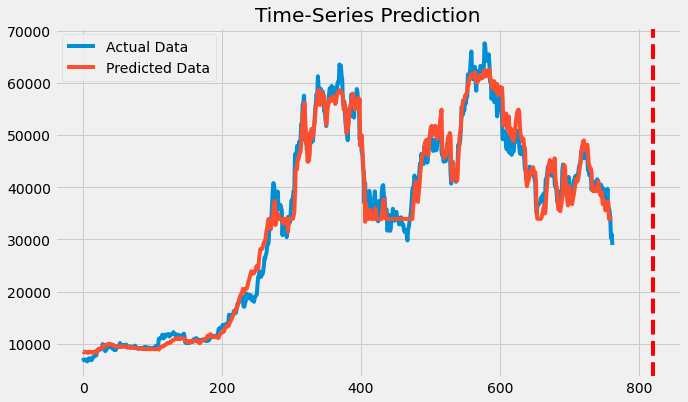

In [75]:
df_X_ss = ss.transform(df.drop(columns=['Close'])) # old transformers
df_y_mm = mm.transform(df.Close.values.reshape(-1, 1)) # old transformers
# split the sequence
df_X_ss, df_y_mm = split_sequences(df_X_ss, df_y_mm, 100, 50)
# converting to tensors
df_X_ss = Variable(torch.Tensor(df_X_ss))
df_y_mm = Variable(torch.Tensor(df_y_mm))
# reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 100, df_X_ss.shape[2]))

train_predict = lstm(df_X_ss) # forward pass
data_predict = train_predict.data.numpy() # numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) # reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
true, preds = [], []
for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=train_test_cutoff, c='r', linestyle='--') # size of the training set

plt.plot(true, label='Actual Data') # actual plot
plt.plot(preds, label='Predicted Data') # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.savefig("whole_plot.png", dpi=300)
plt.show() 

Although this may seem fantastic, it’s not quite as good as it seems. This plot above, where the test data is any time step beyond the red-dashed line, seems to suggest that our model is amazingly accurate at predicting the price of Bitcoin, quite a few months into the future. However, what’s happening here is a form of data leakage: information about the test targets has leaked into our test features. That is, whenever we run the model, it has access to the Open price for that day, which is obviously going to be extremely close to the price Bitcoin ends up at for that particular time-step. When we loop over our predictions on the model, we append the first predicted value for that time-step. This means that every prediction we are plotting here has the benefit of being the next predicted value, rather than a sequence of 50 values into the future, like we set up in our problem definition.

If we really want to see how our model is performing, we have to feed it the 100 time-steps of features before the final value in the test set, and then use one model forward pass to calculate the 50 time-step prices in the test set. Recall from above that we double-checked our test features in the final batch sample in the test set were the 100 time steps up to the time-step we’re attempting to predict. That is, we feed to model 100 days of information up to 26th November 2021, and get it to predict 50 days of Bitcoin prices, from this day to the 14th January 2022.

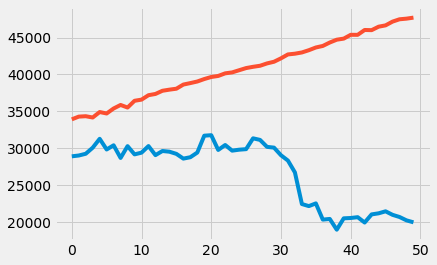

In [76]:
test_predict = lstm(X_test_tensors_final[-1].unsqueeze(0)) # get the last sample
test_predict = test_predict.detach().numpy()
test_predict = mm.inverse_transform(test_predict)
test_predict = test_predict[0].tolist()

test_target = y_test_tensors[-1].detach().numpy() # last sample again
test_target = mm.inverse_transform(test_target.reshape(1, -1))
test_target = test_target[0].tolist()

plt.plot(test_target, label="Actual Data")
plt.plot(test_predict, label="LSTM Predictions")
plt.savefig("small_plot.png", dpi=300)
plt.show();

This is good. If we feed in the last 100 days of information, our model successfully predicts a steady decline in the price of Bitcoin over the next 50 days. For one last plot, let’s put this in perspective of the scale of the data.

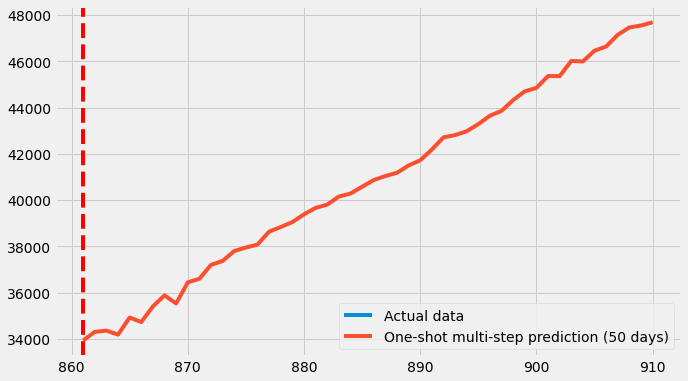

In [77]:
plt.figure(figsize=(10,6)) #plotting
a = [x for x in range(2500, len(y))]
plt.plot(a, y[2500:], label='Actual data');
c = [x for x in range(len(y)-50, len(y))]
plt.plot(c, test_predict, label='One-shot multi-step prediction (50 days)')
plt.axvline(x=len(y)-50, c='r', linestyle='--')
plt.legend()
plt.show()

So, if we’d run our model on 26th November 2021, we would have been correct in selling off our Bitcoin. The model correctly predicts a price drop, as well as the rate at which it drops.

Here’s the amazing part, which took me a while to process. This orange whole curve is generated without looking at any target data. Yes, to be fair, the model is very familiar with all the actual targets before the dashed red line. However, once we move past the training set into the test set, the model has no idea what the test targets are. It has to generate its predictions based on the input features alone. It’s quite remarkable, then, that our orange predictions curve so closely matches that of the actual price.

### Conclusion
Interestingly, there’s essentially no information on the internet on how to construct multi-step output LSTM models for multivariate time-series data. Hopefully, this article gave you both the intuition and technical understanding for building your own forecasting models. Just remember to think through your input and output shapes very carefully, and construct tensors that represent past data predicting future data. Pytorch’s LSTM class will take care of the rest, so long as you know the shape of your data.

In terms of next steps, I would recommend running this model on the most recent Bitcoin data from today, extending back to 100 days previously. See what the model thinks will happen to the price of Bitcoin over the next 50 days. You could also play with the time being fed to the model and the time being forecast; try for longer periods and see if the model can pick up on longer-term dependencies. Finally, you should note that these types of LSTMs are not the only solution to these multivariate, multi-output forecasting problems. There are many other deep learning solutions, including encoder-decoder networks for variable-length sequences, that you should look into. Saying that, LSTMs are a great place to start, and can give incredible performance if you know how to utilise them.